# Capstone Project - Food Classifier

## Overview

The aim of this Capstone Project is to use deep learning to classify images of food. The notebook will include all implementation stages of the project including, data processing, training and building the model and finally an analysis of the results. 

## Software Requirements

The project requires an installation of Anaconda with Python 2. The main libraries use will be Keras with a Tensorflow backend, panda and numpy. 

## Data Processing

The project uses the UECFOOD256 from an academic insitute in Japan, the dataset contains 31,651 images in 256 folders with each folder being a particular category of the food.

In [4]:
from os import listdir
import os.path
import pandas as pd
from sklearn.datasets import load_files    
from sklearn.model_selection import train_test_split
import numpy as np
from shutil import copyfile
from sklearn.datasets import load_files       
from keras.utils import np_utils

raw_dataset = r'UECFOOD256'
categories = r'labels.txt' 
images_folder = r'food-images'
train_folder = os.path.join(images_folder, 'train')
valid_folder = os.path.join(images_folder, 'valid')
test_folder = os.path.join(images_folder, 'test')

def create_folder(folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
        
create_folder(images_folder)
create_folder(train_folder)
create_folder(valid_folder)
create_folder(test_folder)

labels = pd.read_csv(categories, sep=",", header=0)
num_food_labels = len(labels)

def get_label_from_raw(raw_label, labels):
    return labels.iloc[int(raw_label)-1]["name"]

Using TensorFlow backend.


### Cross validation

Currently the images are all grouped together within their labeled folders and they need to be seperated into the training, validation and testing sets for each label. First the names of the files are loaded into a collection, then train_test_split is used to obtain the training and testing set. The method is called again to further split the training data into training and validation sets.

A three folders are created: train, valid, test which each contain a subfolder with the correct label and the images from our cross validation split earlier. The methods are defined here:

In [5]:
# Function to confirm the number of files per label
def get_total_images_per_label(path):
    total = 0
    for item in listdir(path):
        image_folder = os.path.join(path, item)
        if os.path.isdir(image_folder):        
            images = [file for file in os.listdir(image_folder) if file.endswith('.jpg')]
            print('Folder ' + item + ' has ' + str(len(images)) + ' images')
            total = total + len(images)
    print('total files ' + str(total))

def train_validate_test_split(path, raw_label, labels):
    label = get_label_from_raw(raw_label, labels)
    image_folder = os.path.join(path, raw_label)
    files = [file for file in os.listdir(image_folder) if file.endswith('.jpg')]  

    X = np.vstack(files)
    y = np.vstack([label] * len(files))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
        
    return X_train, X_val, X_test, y_train,  y_val, y_test

def copy_images_to_folder(src_folder, set_folder, food_label, images):
    target_folder = os.path.join(set_folder, food_label)
    if not os.path.exists(target_folder):
        os.mkdir(target_folder)
    for image in images:        
        src = os.path.join(src_folder, image[0])
        dst = os.path.join(target_folder, image[0])
        copyfile(src, dst)        
        
def split_and_transfer_raw_images(raw_dataset, labels):    
    raw_labels = [int(folder) for folder in listdir(raw_dataset) if os.path.isdir(os.path.join(raw_dataset, folder))]
    sorted_labels = sorted(raw_labels)
    for raw_label in raw_labels:
        if raw_label < 5:
            raw_label = str(raw_label)
            X_train, X_val, X_test, y_train,  y_val, y_test = train_validate_test_split(raw_dataset, raw_label, labels) 
            food_label = raw_label + '.' + get_label_from_raw(raw_label, labels)
            src_folder = os.path.join(raw_dataset, raw_label)
            copy_images_to_folder(src_folder, train_folder, food_label, X_train)
            copy_images_to_folder(src_folder, valid_folder, food_label, X_val)
            copy_images_to_folder(src_folder, test_folder, food_label, X_test)        

The cross validation split is performed here:

In [5]:
split_and_transfer_raw_images(raw_dataset, labels)

The data is now loaded:

In [6]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), len(labels))
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_folder)
valid_files, valid_targets = load_dataset(valid_folder)
test_files, test_targets = load_dataset(test_folder)

# print statistics about the dataset
print('There are %d total food categories.' % num_food_labels)
print('There are %s total food images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training food images.' % len(train_files))
print('There are %d validation food images.' % len(valid_files))
print('There are %d test food images.'% len(test_files))

There are 256 total food categories.
There are 986 total food images.

There are 707 training food images.
There are 179 validation food images.
There are 100 test food images.


In [8]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator()


### Image Resize

As we construct tensors from the images, they need to be resized order to standardize the input dimensions for the convolutional neural network. 

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Loading the images

In [10]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 100/100 [00:02<00:00, 37.23it/s]


After creating the tensors we can view how thye've been resized:

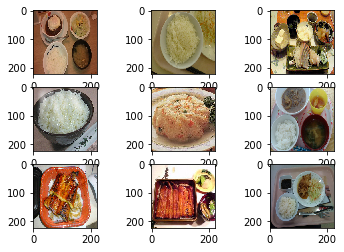

In [11]:
from matplotlib import pyplot
# create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train_tensors[i], cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()

In [9]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_food_labels, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
%%time
from keras.callbacks import ModelCheckpoint  

epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 707 samples, validate on 179 samples
Epoch 1/5
707/707 [==============================] - 36s - loss: 2.2694 - acc: 0.6096 - val_loss: 1.1889 - val_acc: 0.6257
Epoch 2/5
707/707 [==============================] - 35s - loss: 1.1462 - acc: 0.6308 - val_loss: 1.1669 - val_acc: 0.6257
Epoch 3/5
707/707 [==============================] - 35s - loss: 1.1264 - acc: 0.6308 - val_loss: 1.1539 - val_acc: 0.6257
Epoch 4/5
707/707 [==============================] - 35s - loss: 1.1277 - acc: 0.6308 - val_loss: 1.1549 - val_acc: 0.6257
Epoch 5/5
707/707 [==============================] - 35s - loss: 1.1016 - acc: 0.6308 - val_loss: 1.1190 - val_acc: 0.6257
CPU times: user 6min 39s, sys: 1min 8s, total: 7min 48s
Wall time: 2min 59s


In [65]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [68]:
food_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
print(test_tensors[0])
# report test accuracy
test_accuracy = 100*np.sum(np.array(food_predictions)==np.argmax(test_targets, axis=1))/len(food_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

[[[ 0.72941178  0.75294119  0.73725492]
  [ 0.72156864  0.75686276  0.73725492]
  [ 0.72156864  0.75686276  0.74509805]
  ..., 
  [ 0.65098041  0.70588237  0.74117649]
  [ 0.65882355  0.71372551  0.74901962]
  [ 0.63921571  0.70588237  0.73725492]]

 [[ 0.71764708  0.75294119  0.74117649]
  [ 0.71372551  0.74901962  0.73725492]
  [ 0.72156864  0.75686276  0.74509805]
  ..., 
  [ 0.67843139  0.73333335  0.76862746]
  [ 0.68627453  0.74509805  0.77254903]
  [ 0.67058825  0.74117649  0.75686276]]

 [[ 0.71764708  0.75686276  0.75294119]
  [ 0.71764708  0.75294119  0.74117649]
  [ 0.72156864  0.75686276  0.74509805]
  ..., 
  [ 0.66274512  0.71764708  0.75294119]
  [ 0.66274512  0.72156864  0.74901962]
  [ 0.64705884  0.71764708  0.73333335]]

 ..., 
 [[ 0.44313726  0.53725493  0.44313726]
  [ 0.45490196  0.54509807  0.47450981]
  [ 0.4509804   0.5411765   0.47058824]
  ..., 
  [ 0.16470589  0.07450981  0.11372549]
  [ 0.16470589  0.07058824  0.05490196]
  [ 0.1254902   0.07843138  0.08627

In [3]:
# Image augmentation, whitening, create base model, create advanced models, record results, use transfer learning
# Graphs visuals for results, diagram of architeture, sample images, show whitening process
# Do write up in pdf 9 -15 pages
# Write a readme
# contents page for ipython